In [1]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../')
sys.path.append('../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [2]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [3]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
#from dustmaps.bayestar import BayestarQuery

#coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
#bsq = BayestarQuery()
#ebv = bsq.query(coords)
#
#coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
#print('E(B-V) = {:.3f} mag'.format(ebv))
##print(ebv)

In [4]:
ls

01_apo_match.ipynb     02_photometry.ipynb  apo/             spectra/
01_falcon_match.ipynb  03_wd_spectra.ipynb  credentials.txt  stefan.mplstyle
01_sdss4_match.ipynb   04_ms_spectra.ipynb  data/            Untitled.ipynb
01_sdss5_match.ipynb   05_relation.ipynb    sdss5/


In [5]:
from astropy.table import Table, vstack, unique

ms_sdss4_wd_sdss4 = Table.read('data/ms_sdss4_wd_sdss4.fits')
ms_gaia_wd_sdss4 = Table.read('data/ms_gaia_wd_sdss4.fits')
ms_sdss5_wd_sdss4 = Table.read('sdss5/ms_sdss5_wd_sdss4.fits')

ms_gaia_wd_sdss5 = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_sdss4_wd_sdss5 = Table.read('sdss5/ms_sdss4_wd_sdss5.fits')
ms_sdss5_wd_sdss5 = Table.read('sdss5/ms_sdss5_wd_sdss5.fits')

ms_gaia_wd_falcon = Table.read('data/ms_gaia_wd_falcon.fits')
gemini = Table.read('data/gemini.fits')


def strip(catalog):  
    drop_cols = []
    keep_cols = ['wd_source_id', 'ms_source_id', 'wd_l', 'wd_b', 'ms_parallax', 'ms_parallax_over_error', 'wd_ra', 'wd_dec', 
                 'wd_bp_rp', 'wd_phot_g_mean_mag', 'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux', 'wd_phot_bp_mean_flux', 'wd_phot_rp_mean_flux',
                 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error', 'uses_sdss5']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

ms_gaia_wd_sdss4  = strip(ms_gaia_wd_sdss4 )
ms_sdss4_wd_sdss4 = strip(ms_sdss4_wd_sdss4)
ms_sdss5_wd_sdss4 = strip(ms_sdss5_wd_sdss4)

ms_gaia_wd_sdss5  = strip(ms_gaia_wd_sdss5 )
ms_sdss4_wd_sdss5 = strip(ms_sdss4_wd_sdss5)
ms_sdss5_wd_sdss5 = strip(ms_sdss5_wd_sdss5)

ms_gaia_wd_falcon = strip(ms_gaia_wd_falcon)
gemini = strip(gemini)

catalog = unique(vstack([ms_sdss4_wd_sdss4, ms_gaia_wd_sdss4, ms_sdss4_wd_sdss5, ms_sdss5_wd_sdss4, ms_gaia_wd_sdss5, ms_sdss5_wd_sdss5, ms_gaia_wd_falcon, gemini]), keys = 'wd_source_id')

In [6]:
print(len(catalog))

613


In [7]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = (len(catalog)+100) // 100

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id, dist.r_med_geo
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24it/s]


In [8]:
catalog['r_est'] = -999*np.ones(len(catalog))
catalog['uses_bjd'] = [True for i in range(len(catalog))]

for i in tqdm(range(len(catalog))):
    for j in range(len(gaia_d1)):
        if catalog['ms_source_id'][i] == gaia_d1['source_id'][j]:
            catalog['r_est'][i] = gaia_d1['r_med_geo'][j]
            
    if catalog['r_est'][i] < 0:
        catalog['r_est'][i] = 1000 / catalog['ms_parallax'][i]
        
        catalog['uses_bjd'][i] = False

100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [00:08<00:00, 70.49it/s]


In [9]:
catalog.remove_column('ms_source_id')

In [10]:
coords = [SkyCoord(frame="galactic", l=catalog['wd_l'][i]*u.deg, b=catalog['wd_b'][i]*u.deg, distance = catalog['r_est'][i] * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [11]:
catalog[394]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_phot_g_mean_mag,wd_phot_g_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_mag,wd_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_mag,wd_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_est,uses_bjd,wd_coords
,,,,,,,,,,,,,,,,,,,,"deg,deg,pc"
int64,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float64,float64,float64,bool,SkyCoord
2682808784091201664,8.276981261762439,517.5143,19.528942,290.6495288106169,1.2219176,19.827038,160.17748118751027,11.918251,19.008102,197.65945206629456,14.12292,0.8189354,332.2340621093803,2.138531068538412,63.15569520988561,-41.14748729146058,1.0,120.24686431884766,True,"63.15569520988561,-41.14748729146058,120.24686431884766"


In [12]:
#ebv = []
#flag1 = []
#flag2 = []
#
#for i in tqdm(range(len(catalog))):
#    bsq_res = bsq.query(catalog['wd_coords'][i], return_flags = True)
#        
#    ebv.append(bsq_res[0])
#    flag1.append(bsq_res[1][0])
#    flag2.append(bsq_res[1][1])
#    
#catalog['E(B-V)'] = ebv
#catalog['converged'] = flag1
#catalog['reliable_dist'] = flag2

In [13]:
gaia_d1

source_id,r_med_geo
,pc
int64,float32
78630547564037504,201.1547
90243761175084672,202.17758
91690164426524288,88.40844
235840678609579904,344.55997
290678443086494848,61.052753
299817274499164416,250.11562
300721519733864192,181.56036
361278462663417088,199.96817


In [14]:
#catalog['A_g'] = np.repeat(np.nan, len(catalog))
#catalog['A_bp'] = np.repeat(np.nan, len(catalog))
#catalog['A_rp'] = np.repeat(np.nan, len(catalog))
#
#for obj in tqdm(catalog):
#    obj['A_g'] = obj['E(B-V)'] * 3.518
#    obj['A_bp'] = obj['E(B-V)'] * 2.617
#    obj['A_rp'] = obj['E(B-V)'] * 1.971
#    
#catalog['dered_g'] = catalog['u'] - catalog['A_u']
#catalog['dered_bp'] = catalog['g'] - catalog['A_g']
#catalog['dered_rp'] = catalog['r'] - catalog['A_r']
#
#catalog['r_est'] = 1000 / catalog['ms_parallax']

In [15]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['bp-rp', 'G'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

#fitsed_sdss = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr'])#, 'Si', 'Sz'])
fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['bp', 'rp']


In [16]:
def mag_to_flux(mag):
    return 10 ** ((mag )/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux)
    
def get_model_flux_gaia(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed_gaia.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux_gaia(params))

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [17]:
def get_parameters_gaia(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'nedler')
    
    #result.params.pretty_print()
        
    return result

In [18]:
gaia_results = []
gaia_results7 = []
gaia_results9 = []

sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818

e_results = []

logg_vary = []

id_ = []

for i in tqdm(range(len(catalog))):
    id_.append(i)
    
    #obs_mag = np.array([catalog['wd_phot_g_mean_mag'][i], catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]])
    obs_mag_gaia = np.array([catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]])
    
    #e_obs_mag = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error'][i]/catalog['wd_phot_g_mean_flux'][i])**2 + sigmaG_0**2), 
    #                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
    #                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)])
    e_obs_mag_gaia = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
                                   np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)])
        
    #obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i]])
    #e_obs_mag = np.array([catalog['u_err'][i], catalog['g_err'][i], catalog['r_err'][i]])
    
    gaia_logg7 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    gaia_logg8 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    gaia_logg9 = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #vary_logg = get_parameters_gaia(obs_mag_gaia, e_obs_mag_gaia, vary_logg=True, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    
    #sdss_logg7 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    #sdss_logg8 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]])
    #sdss_logg9 = get_parameters_sdss(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
        
    gaia_results.append(gaia_logg8)
    gaia_results7.append(gaia_logg7)
    gaia_results9.append(gaia_logg9)
    
    #logg_vary.append(vary_logg.params['radius'].value)
    
    #sdss_results.append(sdss_logg8)
    #sdss_results7.append(sdss_logg7)
    #sdss_results9.append(sdss_logg9)
    
catalog['wd_catalog_id_phot'] = id_
results = gaia_results

100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [00:32<00:00, 18.93it/s]


In [19]:
i = 394

np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error'][i]/catalog['wd_phot_g_mean_flux'][i])**2 + sigmaG_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)])


array([0.00533168, 0.08083404, 0.0776687 ])

In [21]:


for i in range(len(gaia_results)):
    if gaia_results[i].params['radius'].stderr is None:
        gaia_results[i].params['radius'].stderr = 0



In [22]:
#catalog['raw_radius_result'] = [result for result in sdss_results]
#catalog['radius'] = [result.params['radius'].value for result in sdss_results]
#catalog['phot_teff'] = [result.params['teff'].value for result in sdss_results]
#catalog['e_phot_teff'] = [result.params['teff'].stderr for result in sdss_results]
#catalog['redchi'] = [result.redchi for result in sdss_results]
#catalog['e_radius'] = [np.sqrt(sdss_results[i].params['radius'].stderr**2 + np.abs(sdss_results7[i].params['radius'].value - sdss_results9[i].params['radius'].value)**2 ) for i in range(len(sdss_results))]
#catalog['error_from_model'] = [np.abs(sdss_results7[i].params['radius'].value - sdss_results9[i].params['radius'].value) for i in range(len(sdss_results))]

catalog['raw_radius_result'] = [result for result in gaia_results]
catalog['radius'] = [result.params['radius'].value for result in gaia_results]
catalog['phot_teff'] = [result.params['teff'].value for result in gaia_results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in gaia_results]
catalog['redchi'] = [result.redchi for result in gaia_results]
catalog['e_radius'] = [np.sqrt(gaia_results[i].params['radius'].stderr**2 + np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value)**2 ) for i in range(len(gaia_results))]
catalog['error_from_model'] = [np.abs(gaia_results7[i].params['radius'].value - gaia_results9[i].params['radius'].value) for i in range(len(gaia_results))]

#logg_pctdiff = (logg_vary - catalog['radius']) / catalog['radius']

In [23]:
#print(np.median(logg_pctdiff))
#plt.hist(logg_pctdiff)
#plt.xlabel(r'% difference between $R_\odot$ when $\log g=8$ and $\log g$ varies')

In [24]:
from astropy.table import Table, Column, MaskedColumn, join, unique


print(len(catalog))
print(len(unique(catalog, keys = 'wd_source_id')))

613
613


0.03679545899420171


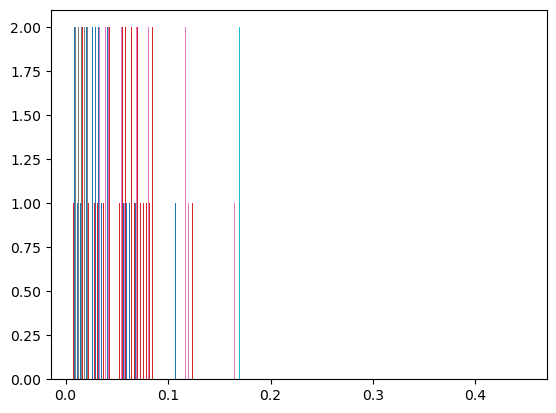

In [25]:
e_obs_mags = []

for p in range(len(catalog)):
    #obs_mag = np.array([catalog['wd_phot_g_mean_mag'][p], catalog['wd_phot_bp_mean_mag'][p], catalog['wd_phot_rp_mean_mag'][p]])
    obs_mag = np.array([catalog['wd_phot_bp_mean_mag'][p], catalog['wd_phot_rp_mean_mag'][p]])
    
    #e_obs_mag = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_g_mean_flux_error'][p]/catalog['wd_phot_g_mean_flux'][p])**2 + sigmaG_0**2), 
    #                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][p]/catalog['wd_phot_bp_mean_flux'][p])**2 + sigmaGBP_0**2), 
    #                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][p]/catalog['wd_phot_rp_mean_flux'][p])**2 + sigmaGRP_0**2)])
    e_obs_mag = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][p]/catalog['wd_phot_bp_mean_flux'][p])**2 + sigmaGBP_0**2), 
                                   np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][p]/catalog['wd_phot_rp_mean_flux'][p])**2 + sigmaGRP_0**2)])
    
    e_obs_mags.append(e_obs_mag)

plt.hist(e_obs_mags)
print(np.median(e_obs_mags))

In [26]:
for i in tqdm(range(len(catalog))):
    bands = ['bp', 'rp']#, 'i', 'z']
    
    fig = plt.figure(figsize = (8,7))
    plt.errorbar(bands, np.array([catalog['wd_phot_bp_mean_mag'][i], catalog['wd_phot_rp_mean_mag'][i]]),#, catalog['i'][i] + 0.015, catalog['z'][i] + 0.030],
                 yerr = np.array([np.sqrt((-2.5/np.log(10)*catalog['wd_phot_bp_mean_flux_error'][i]/catalog['wd_phot_bp_mean_flux'][i])**2 + sigmaGBP_0**2), 
                               np.sqrt((-2.5/np.log(10)*catalog['wd_phot_rp_mean_flux_error'][i]/catalog['wd_phot_rp_mean_flux'][i])**2 + sigmaGRP_0**2)]),#, catalog['i_err'][i], catalog['z_err'][i]],
                 linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
    plt.plot(bands, get_model_flux_gaia(results[i].params), 'bo', markersize = 10, label = 'Model SED')
    plt.title('SED {}'.format(catalog['wd_catalog_id_phot'][i]))
    plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(results[i].params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.20, r'$logg = ${} '.format(results[i].params['logg'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.15, r'$dist = ${} $pc$'.format(results[i].params['distance'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.36, r'$bp-rp = ${}'.format(catalog['wd_bp_rp'][i]), transform = plt.gca().transAxes, fontsize=20)
    plt.xlabel('Band')
    plt.ylabel('Apparent Flux)')
    plt.gca().invert_yaxis()
    plt.legend() 
    plt.savefig('spectra/leastsq/phot_fit/{}.png'.format(catalog['wd_catalog_id_phot'][i]))
    plt.close()

100%|█████████████████████████████████████████████████████████████████████████████████| 613/613 [01:15<00:00,  8.15it/s]


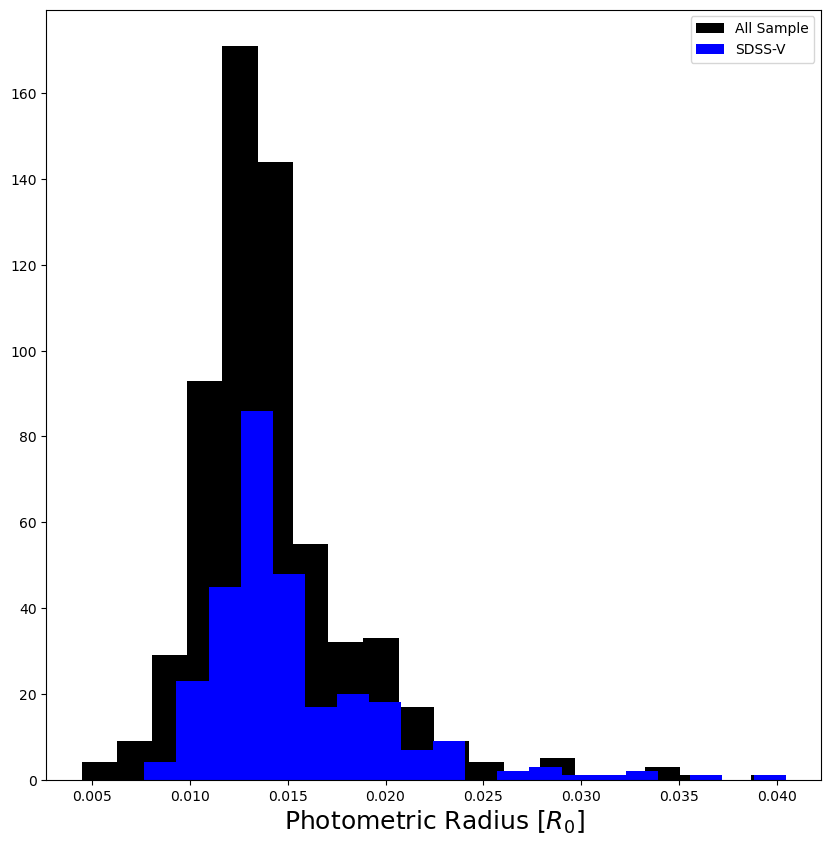

In [27]:
plt.figure(figsize=(10,10))
plt.hist(catalog['radius'], bins = 20, color='black', label = 'All Sample')
plt.hist(catalog['radius'][catalog['uses_sdss5'] == 1], bins = 20, color='blue', label = 'SDSS-V')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_0]$', fontsize=18)
plt.legend()

In [28]:
print(catalog[catalog['wd_catalog_id_phot'] == 221]['radius'])

       radius       
--------------------
0.018287360766838383


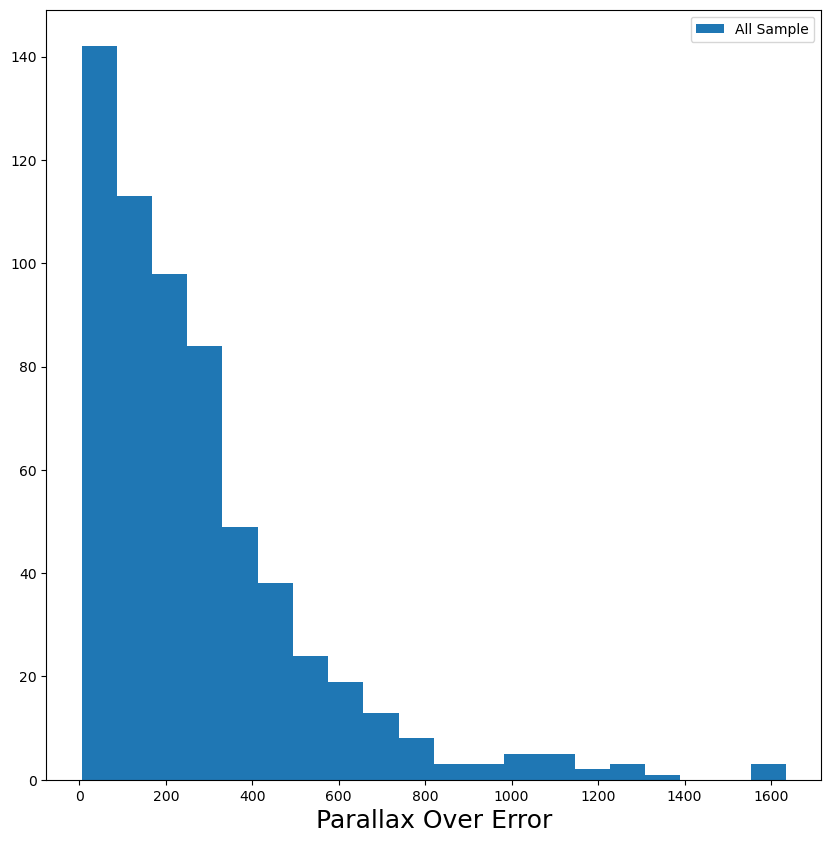

In [29]:
plt.figure(figsize=(10,10))
plt.hist(catalog['ms_parallax_over_error'], bins = 20, label = 'All Sample')
ymin, ymax = plt.ylim()
#plt.vlines(np.mean(catalog['phot_teff']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Parallax Over Error', fontsize=18)
plt.legend()

In [30]:
for key in catalog.keys():
    print(key)
    print(type(catalog[key]))

wd_source_id
<class 'astropy.table.column.MaskedColumn'>
ms_parallax
<class 'astropy.table.column.Column'>
ms_parallax_over_error
<class 'astropy.table.column.Column'>
wd_phot_g_mean_mag
<class 'astropy.table.column.Column'>
wd_phot_g_mean_flux
<class 'astropy.table.column.Column'>
wd_phot_g_mean_flux_error
<class 'astropy.table.column.Column'>
wd_phot_bp_mean_mag
<class 'astropy.table.column.Column'>
wd_phot_bp_mean_flux
<class 'astropy.table.column.Column'>
wd_phot_bp_mean_flux_error
<class 'astropy.table.column.Column'>
wd_phot_rp_mean_mag
<class 'astropy.table.column.Column'>
wd_phot_rp_mean_flux
<class 'astropy.table.column.Column'>
wd_phot_rp_mean_flux_error
<class 'astropy.table.column.Column'>
wd_bp_rp
<class 'astropy.table.column.Column'>
wd_ra
<class 'astropy.table.column.Column'>
wd_dec
<class 'astropy.table.column.Column'>
wd_l
<class 'astropy.table.column.Column'>
wd_b
<class 'astropy.table.column.Column'>
uses_sdss5
<class 'astropy.table.column.MaskedColumn'>
r_est
<class

In [31]:
print(catalog['wd_source_id'])

    wd_source_id   
-------------------
  78630783787018624
  90244375354955392
  91690164426711040
 235840781689958016
 290678477446232960
 299817270203790464
 300721515441972608
 361278458368372992
 520790043346964608
 545940164944375296
                ...
6431084300169300224
6886973535081311872
6898255177217741952
6898705800892401280
6899127085644261632
6899212229075129344
6908407066861225728
6910805342238827648
6915121784373453184
6915495141583341824
Length = 613 rows


In [32]:
gemini['wd_source_id']

3053811568108421504
3630648387747801088


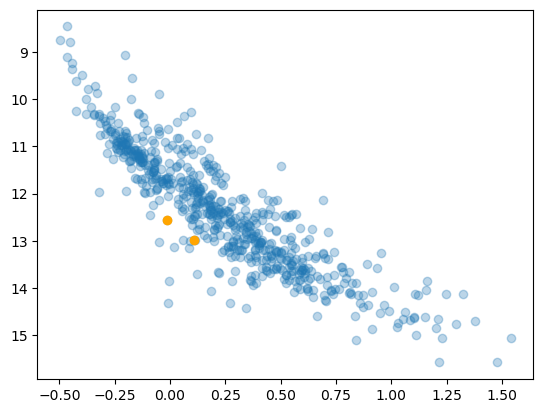

In [33]:
plt.scatter(catalog['wd_bp_rp'], catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100), alpha = 0.3) 
plt.scatter(gemini['wd_bp_rp'], 
            gemini['wd_phot_g_mean_mag'] + 5 * np.log10(gemini['ms_parallax'] / 100), color = 'orange') 
plt.gca().invert_yaxis()


In [34]:
catalog[catalog['wd_source_id'] == 3053811568108421504]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_phot_g_mean_mag,wd_phot_g_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_mag,wd_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_mag,wd_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_est,uses_bjd,wd_coords,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,,,
int64,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float64,float64,float64,bool,SkyCoord,int64,object,float64,float64,object,float64,float64,float64
3053811568108421504,8.814823841102658,562.90454,18.264591,931.34487877912,1.6410568,16.315458,4066.6181639998103,504.16125,16.205353,2612.2637151541453,226.58652,0.110105515,111.21333342851565,-8.435096265944722,224.26130255913728,3.4981603272489012,--,113.09884643554688,True,"224.26130255913728,3.4981603272489012,113.09884643554688",427,<lmfit.minimizer.MinimizerResult object at 0x7f4b62f3de50>,0.021462508904008318,10019.716484278106,None,1.6499252472177877e-14,0.000611190810648251,0.000611190810648251


In [35]:
catalog[catalog['wd_source_id'] == 3630648387747801088]

wd_source_id,ms_parallax,ms_parallax_over_error,wd_phot_g_mean_mag,wd_phot_g_mean_flux,wd_phot_g_mean_flux_error,wd_phot_bp_mean_mag,wd_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,wd_phot_rp_mean_mag,wd_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,wd_bp_rp,wd_ra,wd_dec,wd_l,wd_b,uses_sdss5,r_est,uses_bjd,wd_coords,wd_catalog_id_phot,raw_radius_result,radius,phot_teff,e_phot_teff,redchi,e_radius,error_from_model
,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,,,
int64,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float32,float32,float64,float64,float64,float64,float64,float64,bool,SkyCoord,int64,object,float64,float64,object,float64,float64,float64
3630648387747801088,17.712380230989538,1013.46893,16.32448,5561.025933695923,4.075968,16.327034,4023.493468614833,13.082261,16.340994,2305.476418167508,9.632535,-0.013959885,204.91582815570885,-7.221270578957777,323.43072229719735,53.72009508912655,--,56.28651428222656,True,"323.43072229719735,53.72009508912655,56.28651428222656",465,<lmfit.minimizer.MinimizerResult object at 0x7f4b62e8a850>,0.008781873133343799,11486.79540295481,None,4.2925022721134335e-11,0.0006208319423189456,0.0006208319423189456


In [ ]:
catalog.remove_columns(['ms_parallax', 'wd_l', 'wd_b', 'raw_radius_result', 'wd_bp_rp', 'wd_phot_g_mean_mag', 'e_phot_teff',
                        'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'wd_phot_g_mean_flux_error', 'wd_phot_bp_mean_flux_error', 'wd_phot_rp_mean_flux_error'])

for key in catalog.keys():
    print(key)
    print(type(catalog[key]))

In [ ]:
catalog.remove_columns(['wd_coords'])

In [ ]:
for key in catalog.keys():
    print(key)
    print(type(catalog[key][0]))

In [ ]:
catalog.write('data/02_photometry.fits', overwrite=True)

In [ ]:
nug = catalog[['wd_source_id', 'phot_teff']]
nug.pprint()

nug.write('data/nugget.fits', overwrite = True)

In [ ]:
catalog[catalog['wd_source_id'] == 3053811568108421504]